This Jupyter (formerly known as iPython) notebook contains a number of examples on the manipulation data obtained from the trained network. Sections are individually explained. See the comments throughout the code for additional information.

In [1]:
# Populating the environment for numerical analyses. 
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
# To load a previously trained network.
from neurolab import load

# To plot a previously trained network. 
from simulator import plot_net, Model

# Data used to train the network
from wnt_test import training_data


Licence
 Neural Network Simulation of Wnt Signalling Pathway - Version 1, by Pouria Hadjibagheri.
     Copyright (C) 2016, Pouria Hadjibagheri <p.bagheri.12@ucl.ac.uk>

 This program is free software; you can redistribute it and/or modify it under the terms
     of the GNU General Public License as published by the Free Software Foundation; either
     version 2 of the License, or (at your option) any later version.

     This General Public License does NOT permit incorporating this program into proprietary
     programs.

     This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY;
     without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
     See the GNU General Public License for more details.

     You should have received a copy of the GNU General Public License along with this program;
     if not, write to the:
     Free Software Foundation, Inc.,
     51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 

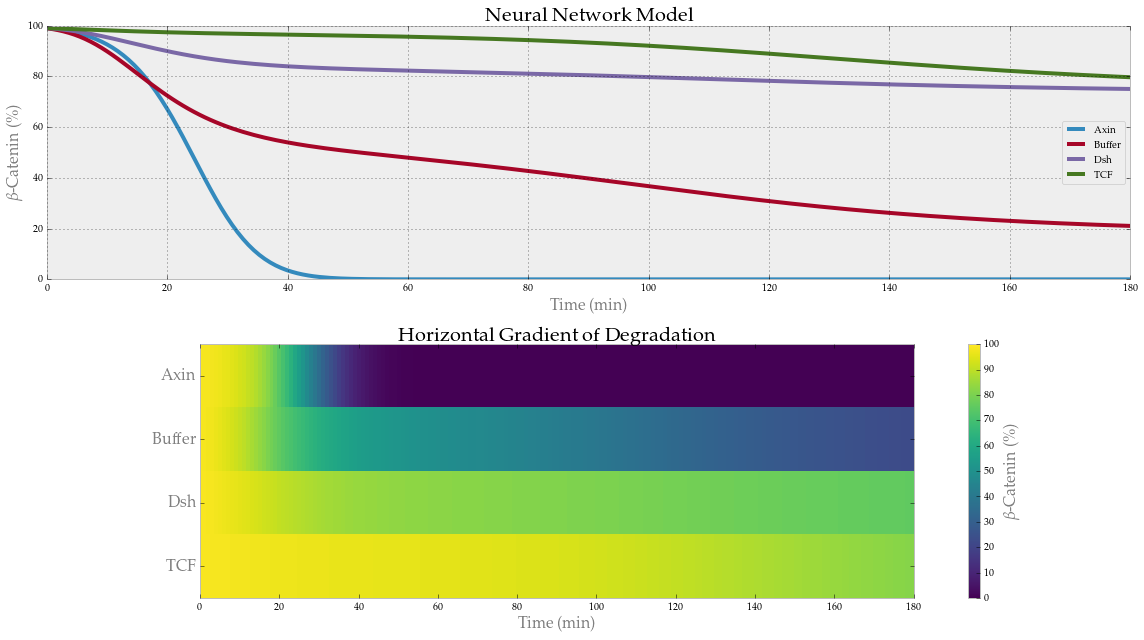

In [17]:
data = Model.prep_args(training_data)
titles = data['titles']

# To load a previously trained. 
net_file = 'Results/bcat.neu'
network = load(net_file)

# Displaying the simulation. 
# Note that the learning curve is not included.
fig = plot_net(network=network, titles=titles)
fig.savefig('./notebook_images/preliminary_results.eps',
            dpi=300,
            format='eps',
            bbox_inches='tight',
            pad_inches=.3,
            transparent=True,
            frameon=None)

In [4]:
# Graph style. 
style.use('bmh')

# Enabling the use of LaTeX in plots.
rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

initial_time = 0
max_samples = 180
max_time = 100
t_span = array(linspace(initial_time, max_time, max_samples))
t_ins = t_span.reshape(-1, 1)

outs = network.sim(t_ins/max_samples) * max_time

# Populating the dict the corresponding data, adjusted (lifted to 100)
items = {
    val: 
        outs[:, titles.index(val)] + (max_time - amax(outs[:, titles.index(val)])) 
    if amax(outs[:, titles.index(val)]) <= max_time else
        outs[:, titles.index(val)] - (amax(outs[:, titles.index(val)]) - max_time)
    for val in titles
}

# Individual components 
The components are adjusted on the basis of their initial value deviation from 100. 

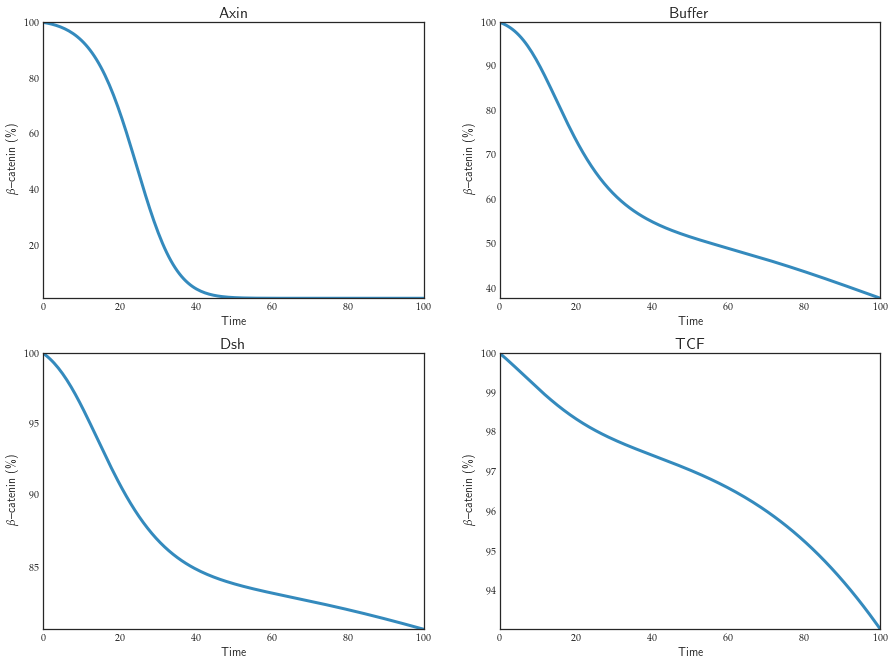

In [5]:
style.use('seaborn-white')
fig = figure(figsize=[15, 15])

for index, value in enumerate(sorted(items)):
    fig.add_subplot(len(items), int(len(items)/2), index+1)
    plot(t_span, items[value], linewidth=3)
    xlabel('Time')
    ylabel(r'$\beta$--catenin (\%)')
    title(value, fontsize=16)
    ylim(amin(items[value]), amax(items[value]))
    
subplots_adjust(top=1.3)

fig.savefig('./notebook_images/individual_adjusted.eps',
            dpi=300,
            format='eps',
            bbox_inches='tight',
            pad_inches=.3,
            transparent=True,
            frameon=None)

# Comparison of ANN and Exponential Decay
Focusing particularly on Axin:

(a) Displays ANN model of $\beta$-catenin degradation.

(b) Displays the gradient of _(a)_.

(c) Displays the exponential decay of Axin calculated on based on the half-life obtained from ANN model:
Decay constant: 

$$\lambda = \frac{-1}{\mathrm{ln}(t_{\frac{1}{2}})} \times \frac{N_0}{\mathrm{ln}({N_{\frac{1}{2}}})}$$

And the decay was calculated as follows:
$$\frac{\mathrm{d}N}{\mathrm{d}t} N_0\mathrm{e}^{-\lambda t} = y \times \lambda-\mathrm{e}^{(\lambda t)}$$

Gradients are calculated using:

$$\vec{\nabla}f=\sum_{i=1}^{n}\left(\frac{\partial f}{\partial x_i}\mathrm{e}_i\right)$$

Where vector $f$ represents the vector containing the values of $\beta$_-catenin_ with respect to time for the first gradient, and  $\beta$_catenin.Axin_ with respect to $\beta$_-catenin_ for the second gradient; $n$ is the length of the the vector, and $\mathrm{e}_i$ is the orthogonal vector of units pointing towards the coordinate directions.

(d) Displays the phase planes and the plot of $k_{\beta-catenin\cdot Axin}$ versus $\vec{\nabla}f_{\beta-Catenin \cdot Axin}$ of ANN simulation. 

Half-life:     approximated at time 24.022 with a value of 50.653.
Decay contant: -0.054.
* Values rounded to 3 decimal places.


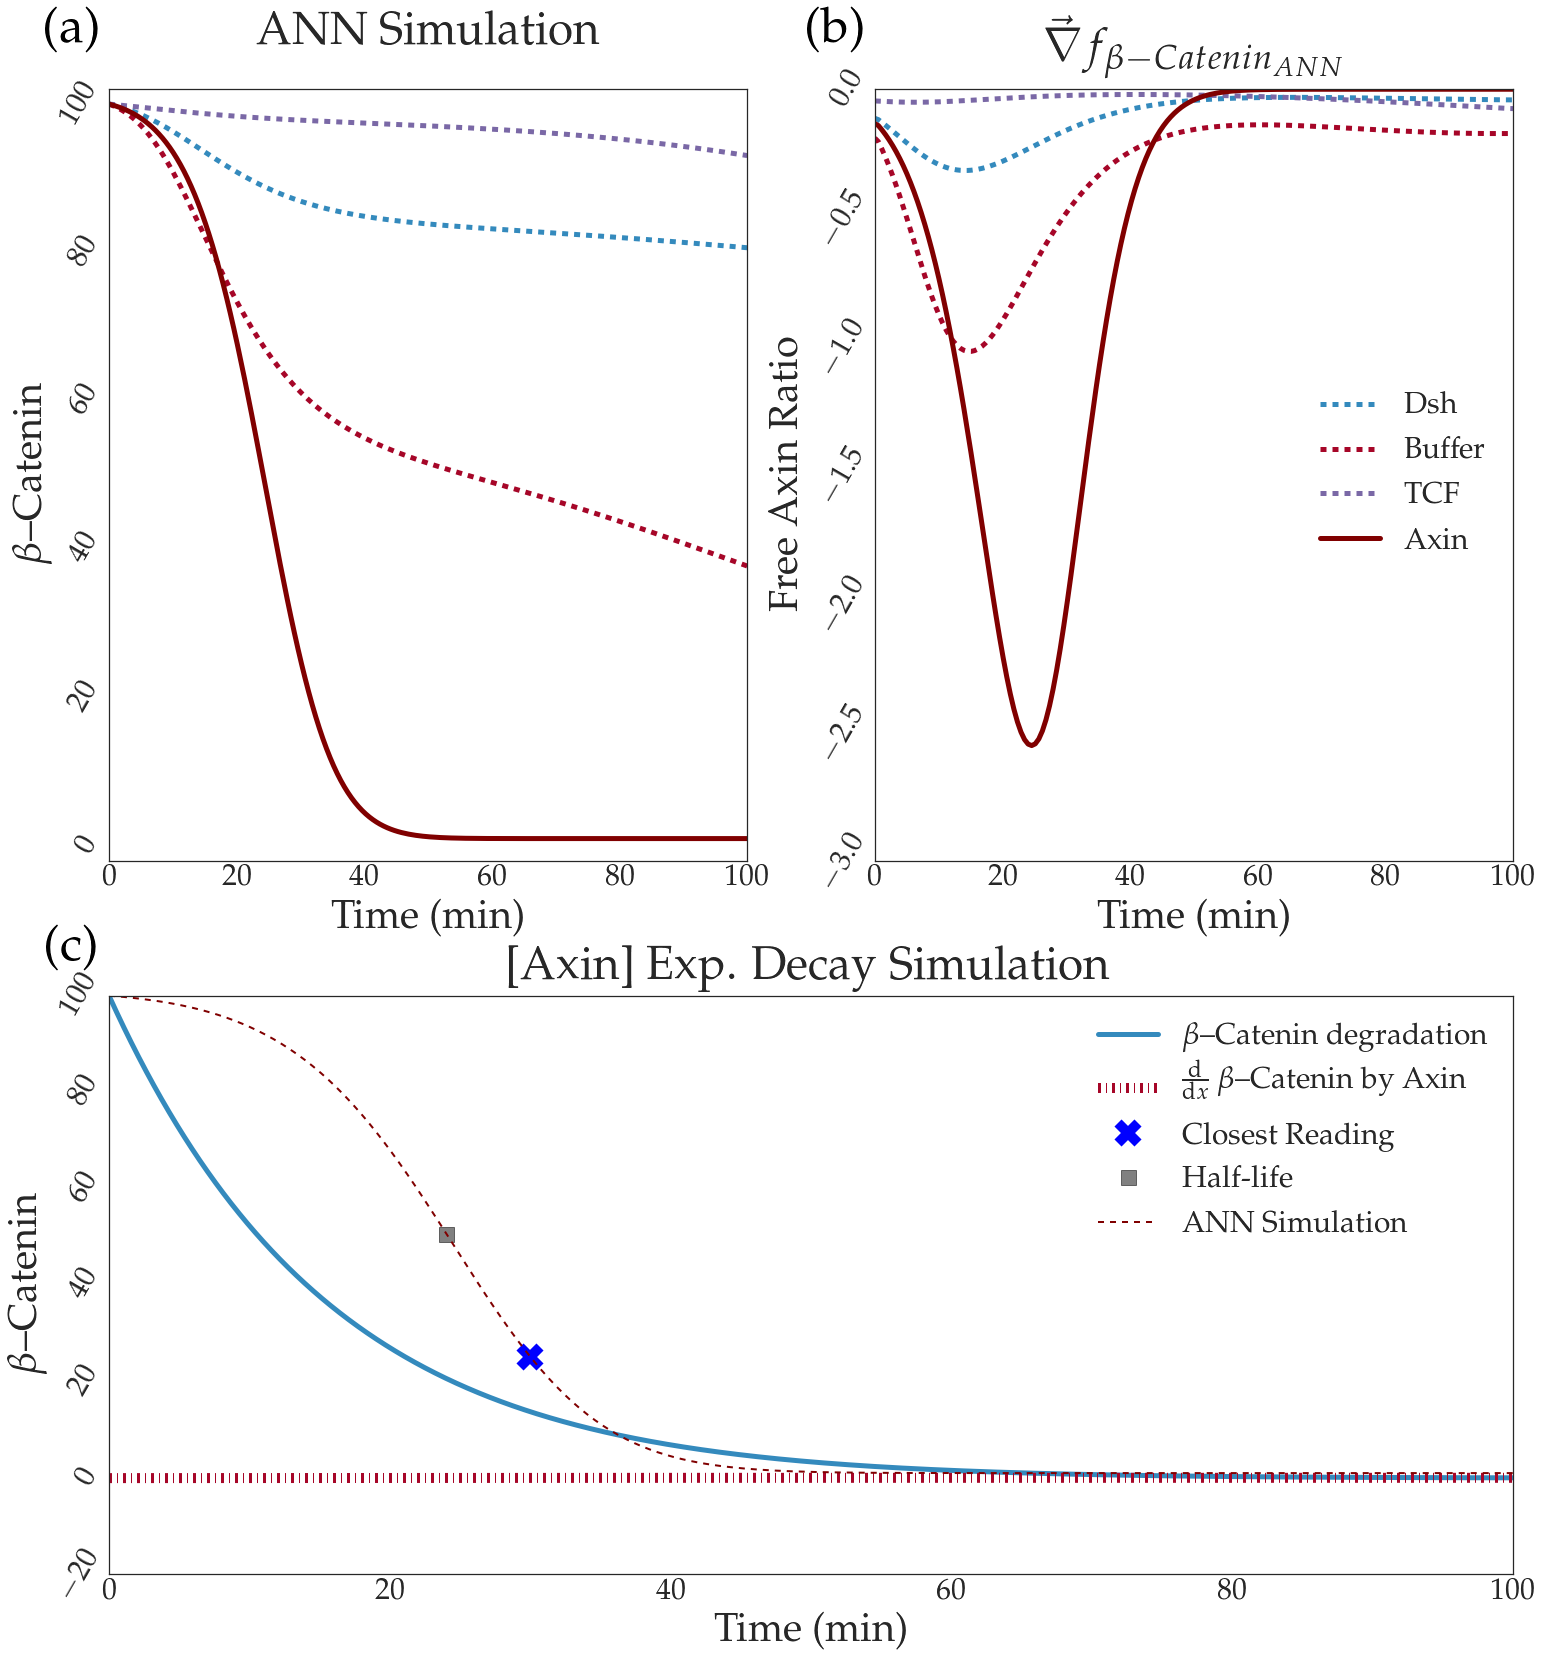

In [319]:
# For ordinary differential equations.
from scipy.integrate import odeint

# For custom grids (plots).
from matplotlib import gridspec

# Graph style. 
style.use('seaborn-white')

# Enabling the use of LaTeX in plots.
rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

# Constants
label_font_size = 40
text_kwargs = dict(ha='center',
                   va='bottom',
                   fontsize=50,
                   color='k',
                   weight='bold')


# Calculating the half-life. 
axin = items['Axin']
axin_list = axin.tolist()

threshold = .0001
while True:
    try:
        # Raises ValueError if no item is found.
        a = axin_list.index(
            axin[isclose(axin, 50, threshold)]
        )
        break
    except ValueError:
        # Doubles the threshold until 
        # a number is returned.
        threshold += threshold

halflife_t = t_span[a]  # Half-life approximation time.
halflife = axin[a]  # Half-life.

# Calculating the decay constant. 
decay_constant = -1 / (log(max_time/halflife_t) * halflife / log(halflife))

def dydt(y, t, k):
    """
    Function for calculating the derivative of the 
    exponential decay.
    :param y: Initial condition.
    :type y: int, float
    :param t: Integration time.
    :type t: int, float
    :param k: Decay constant.
    :type k: int, float, complex
    :return: resp
    :rtype: int, float, complex
    """
    resp = y * k - exp(k*t)
    return resp

# Derivative of the exponential decay.
diff_time = linspace(
    amin(t_span), amax(t_span), int(1e4)
)

exp_decay = odeint(
    func=dydt, 
    y0=100, 
    t=diff_time, 
    args=(decay_constant,)
)[:, 0]

# Gradient of the derivative of the exponential decay.
ddx_exp_decay = gradient(exp_decay)



fig = figure(211, figsize=[20, 15], dpi=100)
custom_grid = gridspec.GridSpec(2, 2, height_ratios=[2, 1.5])


# Display ANN model (a) and gradients thereof (b). 
line_type = lambda x: {
                    'linestyle':'-', 
                    'color':'maroon'
                } if x == 'Axin' else {
                    'linestyle':'--'
                }

for key in items.keys():
    # (a)
    fig.add_subplot(custom_grid[0, 0])
    plot(t_span, items[key], 
         **line_type(key), 
         linewidth=5, 
         label=key)
    xlabel('Time (min)', fontsize=label_font_size)
    ylabel(r'$\beta$--Catenin', fontsize=label_font_size, x=-.1)
    title(r'ANN Simulation', fontsize=46, y=1.05)
    ax1 = gca()
    
    # (b)
    fig.add_subplot(custom_grid[0, 1])
    plot(t_span, gradient(items[key]), 
         **line_type(key), 
         linewidth=5, 
         label=key)
    title(r'$\vec{\nabla}f_{\beta-Catenin_{ANN}}$', fontsize=46, y=1.01)
    xlabel(r'Time (min)', fontsize=label_font_size)
    ylabel(r'Free Axin Ratio', fontsize=label_font_size, x=-.1)
    ax2 = gca() 
    
    legend(fontsize=30, loc=5)

ax1.set_ylim([-2, 102])
ax1.grid('off')
ax2.grid('off')
fig.text(0.1, 1.53, '(a)', text_kwargs)
fig.text(.63, 1.53, '(b)', text_kwargs)


# Plots in (c)
fig.add_subplot(custom_grid[1, :])

# Plot of the exponential decay.
plot(diff_time, exp_decay, 
     linewidth=5,
     label=r'$\beta$--Catenin degradation')

# Plot of the gradient of the exponential decay.
plot(diff_time, ddx_exp_decay, 
     '-.', 
     linewidth=10, 
     label=r'$\frac{\mathrm{d}}{\mathrm{d}x}~\beta$--Catenin by Axin')

# Marking the closest measurement.
plot(training_data['Axin']['measurements'][1][0], 
     training_data['Axin']['measurements'][1][-1], 
     'xb', 
     markersize=20, 
     markeredgewidth=10,
     label='Closest Reading')

# Marking the halflife.
plot(halflife_t, halflife,
     's', 
     markersize=15, 
     label=r'Half-life', 
     color='gray')

# Plot of ANN model for Axin. 
plot(t_span, items['Axin'], 
     '--', 
     color='maroon',
     linewidth=2, 
     label=r'ANN Simulation')

legend(fontsize=30)
title(r'[Axin] Exp. Decay Simulation', fontsize=46, y=1.02)
ylabel(r'$\beta$--Catenin', fontsize=label_font_size, x=-.01)
xlabel('Time (min)', fontsize=label_font_size)
ax3 = gca()
ax3.grid('off')
xlim([initial_time, max_time])
fig.text(.1, .68, '(c)', text_kwargs)


subplots_adjust(top=1.5, right=1.1)


# Adjusting tick labels.
tick_list = [
    ax1.xaxis, ax1.yaxis, 
    ax2.xaxis, ax2.yaxis, 
    ax3.xaxis, ax3.yaxis, 
] # Contains axes to be adjusted.

for ind, item in enumerate(tick_list):
    for tick in item.get_major_ticks():
        tick.label.set_fontsize(30) 
        if bool(ind%2):
            tick.label.set_rotation(60)

print('Half-life:     approximated at time {:.3f} with a value of {:.3f}.\n'
      'Decay contant: {:.3f}.\n* Values rounded to 3 decimal places.'
      .format(halflife_t, halflife, decay_constant))

# Saving the figure on the disk. 
fig.savefig('./notebook_images/exp-ddx.eps',
            dpi=300,
            format='eps',
            bbox_inches='tight',
            pad_inches=.3,
            transparent=True,
            frameon=None)

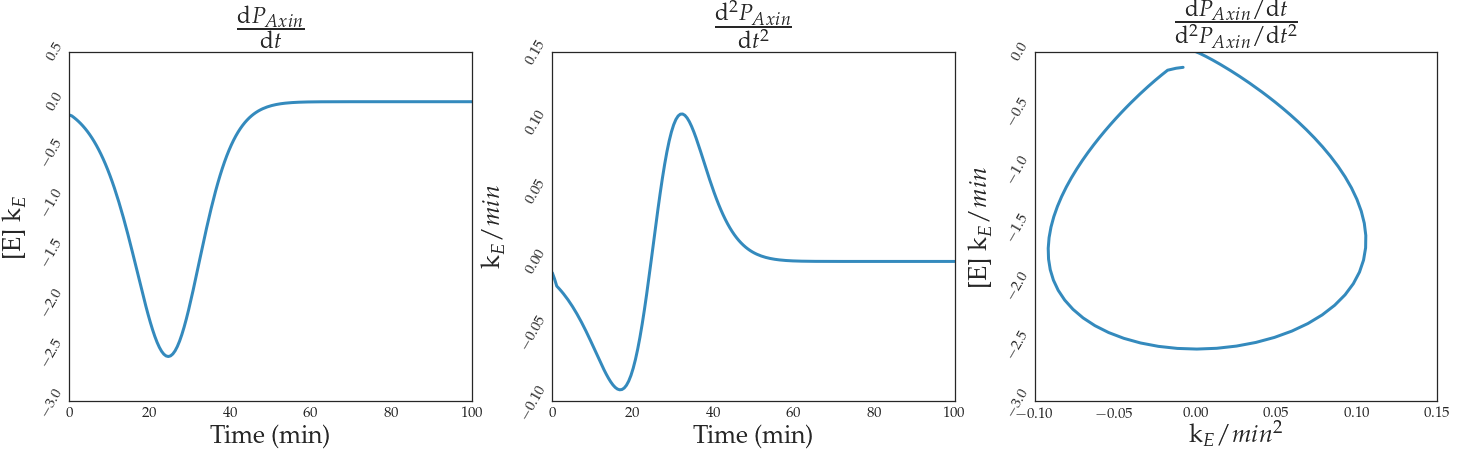

In [427]:
style.use('seaborn-white')
# Enabling the use of LaTeX in plots.
rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

fig = figure(333, figsize=[8, 12])

fig.add_subplot(331)
plot(t_span, gradient(items['Axin']), linewidth=3)
title(r'$\frac{\mathrm{d} P_{Axin}}{\mathrm{d} t}$', fontsize=30)
ylabel(r'[E]~k_E', fontsize=25)
xlabel(r'Time (min)', fontsize=25)
ylim([-3, .5])
ax1 = gca()

fig.add_subplot(332)
plot(t_span, gradient(gradient(items['Axin'])), linewidth=3)
title(r'$\frac{\mathrm{d}^2 P_{Axin}}{\mathrm{d} t^2}$', fontsize=30)
ylabel(r'k_E/min', fontsize=25)
xlabel(r'Time (min)', fontsize=25)
ax2 = gca()

fig.add_subplot(333)
plot(gradient(gradient(items['Axin'])), gradient(items['Axin']), linewidth=3)
title(r'$\frac{\mathrm{d} P_{Axin}/\mathrm{d} t}{\mathrm{d}^2 P_{Axin}/\mathrm{d}t^2}$', fontsize=30)
xlabel(r'k_E / min^2', fontsize=25)
ylabel(r'[E]~k_E / min', fontsize=25)
ax3 = gca()


subplots_adjust(top=1.5, right=2.5)

tick_list = [
    ax1.xaxis, ax1.yaxis, 
    ax2.xaxis, ax2.yaxis, 
    ax3.xaxis, ax3.yaxis, 
] # Contains axes to be adjusted.

for ind, item in enumerate(tick_list):
    for tick in item.get_major_ticks():
        tick.label.set_fontsize(15) 
        if bool(ind%2):
            tick.label.set_rotation(60)
            
fig.savefig('./notebook_images/gradients.png',
            dpi=300,
            format='png',
            bbox_inches='tight',
            pad_inches=.3,
            transparent=True,
            frameon=None)

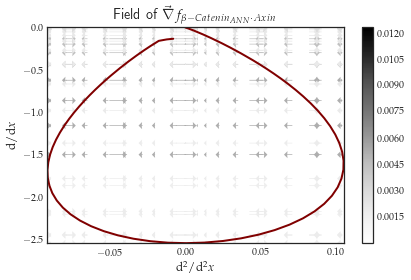

In [7]:
style.use('seaborn-white')

# Plots in (d)
fig = figure()

# Calculating the phase planes.
X1 , Y1  = meshgrid(
                gradient(gradient(items['Axin'])),
                gradient(items['Axin']), 

           ) # create a grid
dx1, dx2 = diff((X1, Y1))
M = hypot(dx1.T, dx2.T) # norm growth rate 
M[M==0]=1

# Plot of the second gradient of Axin.
plot(gradient(gradient(items['Axin'])), gradient(items['Axin']), 
     ls='-', color='maroon')

# Plot of the phase plane.
quiver(X1[::4, ::4], Y1[::4, ::4], dx1[::4, ::4], dx2[::4, ::4], M,
       pivot='mid',
       units='inches', 
       color='b', 
       headwidth=10)

title(r'Field of $\vec{\nabla}f_{\beta-Catenin_{ANN} \cdot Axin}$')
ylabel(r'$\mathrm{d} / \mathrm{d}x$')
xlabel(r'$\mathrm{d}^2 / \mathrm{d}^2 x$')
xlim(amin(X1), amax(X1))
ylim(amin(Y1), amax(Y1))
colorbar()
tight_layout()

fig.savefig('./notebook_images/phase.eps',
            dpi=300,
            format='eps',
            bbox_inches='tight',
            pad_inches=.3,
            transparent=True,
            frameon=None)

# 3D Display 
Values displayed in part 2(a, b, and d) in spacial view. 

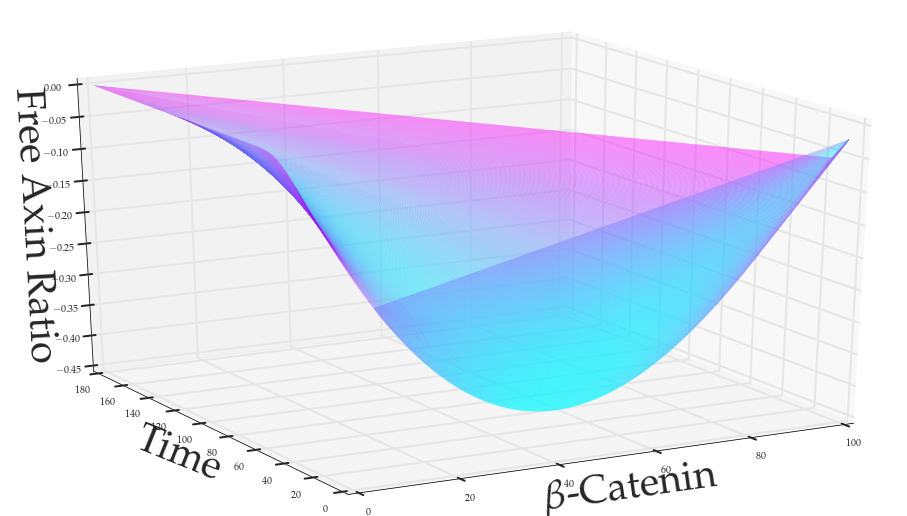

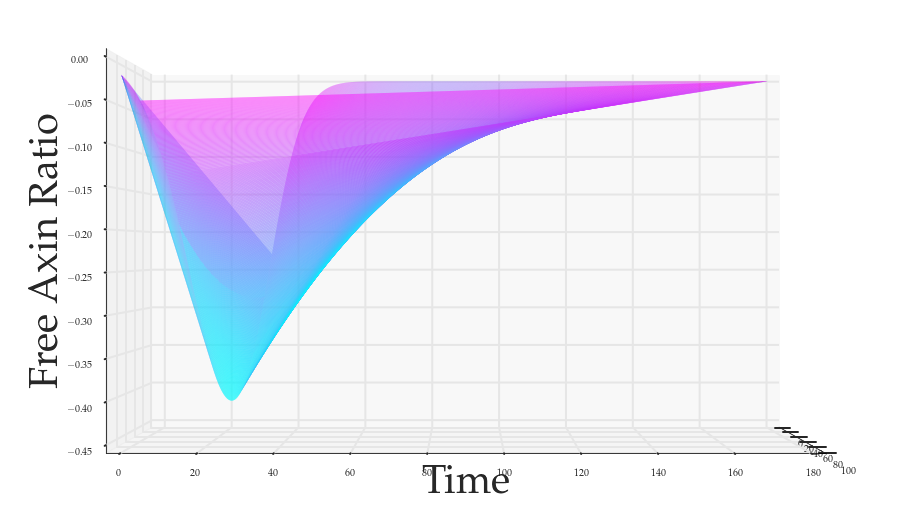

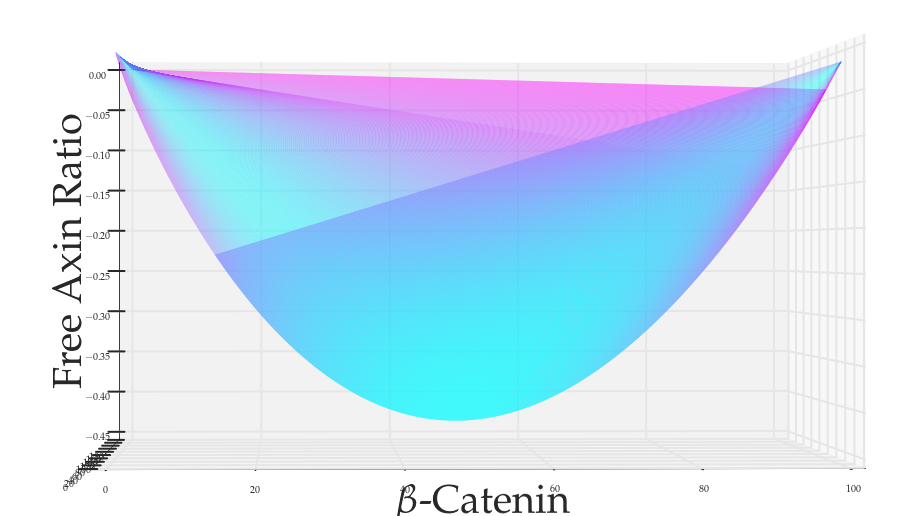

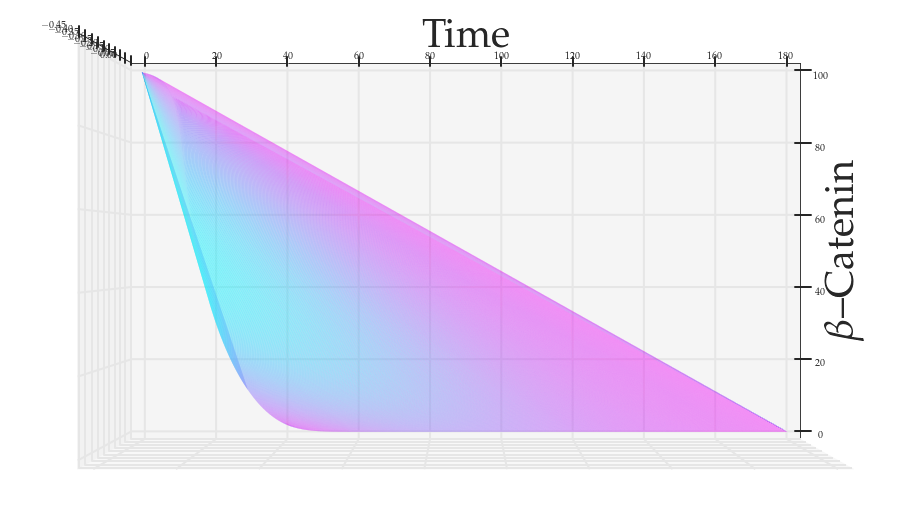

In [318]:
# 3D axes.
from mpl_toolkits.mplot3d import Axes3D 

# Graph style.
style.use('seaborn-white')

# Enabling the use of LaTeX in plots.
rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

# Constants
colour_map = cm.cool
alpha_val = .5
lable_size = 40

x_vals = linspace(0, 180, 2000) 
simulated = (network.sim(x_vals.reshape(-1, 1)/max_samples)*100)[:, titles.index('Axin')] 

fig = list()

# 3D view
fig.append(figure(figsize=[16,9]))
ax = fig[-1].gca(projection='3d') 
ax.plot_trisurf(simulated, x_vals, gradient(simulated), cmap=colour_map, 
                linewidth=0, alpha=alpha_val, antialiased=True) 

ax.set_xlabel(r'$\beta$-Catenin', fontsize=lable_size) 
ax.set_ylabel('Time', fontsize=lable_size, rotation=-22) 
ax.set_zlabel(r'Free Axin Ratio', fontsize=lable_size, rotation='vertical')
ax.view_init(elev=22, azim=-119)
tick_list = [ax.xaxis, ax.yaxis, ax.zaxis]
ax.dist=8.8

# X / Y view.   
fig.append(figure(figsize=[16,9]))
ax = fig[-1].gca(projection='3d') 
ax.plot_trisurf(simulated, x_vals, gradient(simulated), cmap=colour_map, 
                linewidth=0, alpha=alpha_val, antialiased=True) 

ax.set_ylabel('Time', fontsize=lable_size)
ax.set_zlabel(r'Free Axin Ratio', fontsize=lable_size, rotation='vertical')
ax.view_init(elev=0, azim=0)
ax.dist=7.5


# Y / Z view.
fig.append(figure(figsize=[16,9]))
ax = fig[-1].gca(projection='3d') 
ax.plot_trisurf(simulated, x_vals, gradient(simulated), cmap=colour_map, 
                linewidth=0, alpha=alpha_val, antialiased=True) 
ax.set_xlabel(r'$\beta$-Catenin', fontsize=lable_size) 

ax.set_zlabel(r'Free Axin Ratio', fontsize=lable_size, rotation='vertical')
ax.view_init(elev=0, azim=-92)
ax.dist=7

# X / Z view.
fig.append(figure(figsize=[16,9]))
ax = fig[-1].gca(projection='3d') 
ax.plot_trisurf(simulated, x_vals, gradient(simulated), cmap=colour_map,
                linewidth=0, alpha=alpha_val, antialiased=True) 
ax.set_xlabel(r'$\beta$--Catenin', fontsize=lable_size) 
ax.set_ylabel('Time', fontsize=lable_size) 
ax.view_init(elev=-90, azim=0)
ax.dist=7

# Saving the figures on the disk. 
for index, item in enumerate(fig):
    item.savefig('./notebook_images/3d-{}.png'.format(index+1),
                 dpi=300,
                 format='png',
                 bbox_inches='tight',
                 transparent=True,
                 frameon=None)

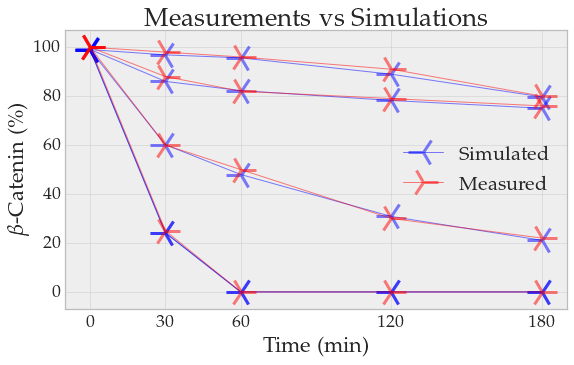

In [316]:
style.use('bmh')
fig = figure(figsize=[9, 5])
t_span_p = array([0, 30, 60, 120, 180]).reshape(-1, 1)
simulated = network.sim(t_span_p / max_samples) * max_time

plt1 = plot(dot(t_span_p, ones([1, simulated.shape[0]])), simulated, '-3b', 
     linewidth=1, markersize=30, markeredgewidth=3, alpha=.5)
ax1 = gca()
plt2 = plot(data['input'].T, data['target'].T, '-4r', 
     linewidth=1, markersize=30, markeredgewidth=3, alpha=.5)
ax2 = gca()
legend([plt1[1], plt2[1]], ['Simulated', 'Measured'], fontsize=20, loc='best')

# Adjusting tick labels.
tick_list = [
    ax1.xaxis, ax1.yaxis, 
    ax2.xaxis, ax2.yaxis, 
] # Contains axes to be adjusted.

for ind, item in enumerate(tick_list):
    for tick in item.get_major_ticks():
        tick.label.set_fontsize(18) 
        
xlim([-10, 190])
ylim([-7, 107])

ax1.set_xticks([0, 30, 60, 120, 180])
xlabel('Time (min)', fontsize=22)
ylabel(r'$\beta$-Catenin (\%)', fontsize=22)
title('Measurements vs Simulations', fontsize=26)

fig.savefig('./notebook_images/all_data.eps',
            dpi=300,
            format='eps',
            transparent=True,
            bbox_inches='tight',
            pad_inches=.3,
            frameon=None)

# Timecourse of [Axin] and [$\beta$-Catenin] on Wnt stimulation
Transient stimulation Wnt amounts to proportional increase in [$\beta$-catenin], which is inversely proportional to [Axin]. 

$$k_{\beta-catenin}: -\vec{\nabla}f_{\beta-cat \cdot Axin}$$

$$k_{Axin}: \vec{\nabla}f_{\beta-cat.Axin}$$

It may therefore be hypothesised that the concentration of Axin $\cdot \beta$--catenin may be calculated through:

$$[Axin\cdot \beta-cat] \propto Axin_{init} \times \mathrm{e}^{\vec{\nabla}f_{\beta-cat.Axin}} $$

Which would be inversely proportional to free [Axin] for a constant.

It also appears that the integral of $[Axin \cdot \beta-cat]$ may be proportional to [Wnt] stimulation:

$$[wnt] \propto \int \vec{\nabla}f_{\beta-cat.Axin}$$

A stimulation constant in needed to account for any divergance. Unfortunately, sufficient data were not available to further explore, or verify the aforementioned hypotheses. 


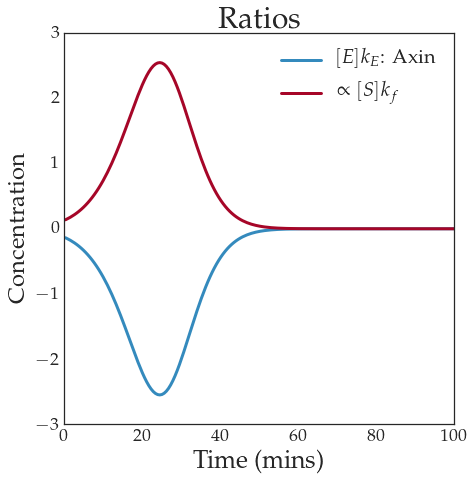

In [431]:
style.use('seaborn-white')
# Enabling the use of LaTeX in plots.
rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

fig = figure(figsize=[7, 7])

# Gradient of Axin and its modulus.
plot(t_span, gradient(items['Axin']), '-', 
     t_span, -gradient(items['Axin']), '-',
    linewidth=3)


legend(['$[E]k_E$: Axin', r'$\propto [S]k_f$'], fontsize=20)
xlabel('Time (mins)', fontsize=25)
ylabel('Concentration', fontsize=24)
title('Ratios', fontsize=30)
xlim(0,100)

ax1 = gca()


for ind, item in enumerate(tick_list):
    for tick in item.get_major_ticks():
        tick.label.set_fontsize(18) 

# Adjusting tick labels.
tick_list = [
    ax1.xaxis, ax1.yaxis, 
]

for ind, item in enumerate(tick_list):
    for tick in item.get_major_ticks():
        tick.label.set_fontsize(18)
   
fig.savefig('./notebook_images/ratios.eps',
             dpi=300,
             format='eps',
             bbox_inches='tight',
             transparent=True,
             frameon=None)

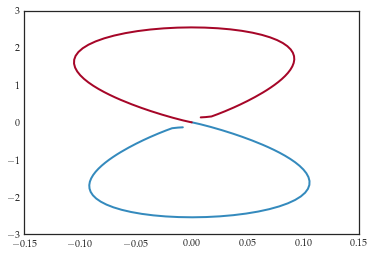

In [10]:
style.use('seaborn-white')

fig = figure()
plot(gradient(gradient(items['Axin'])), gradient(items['Axin']))
plot(gradient(gradient(-items['Axin'])), gradient(-items['Axin']))
ax2 = gca()

fig.savefig('./notebook_images/ration_phase.eps',
            dpi=300,
            format='eps',
            bbox_inches='tight',
            pad_inches=.3,
            transparent=True,
            frameon=None)

This is merely an example of how input data fed to the system directly from the microscopy/micro-array may look like.

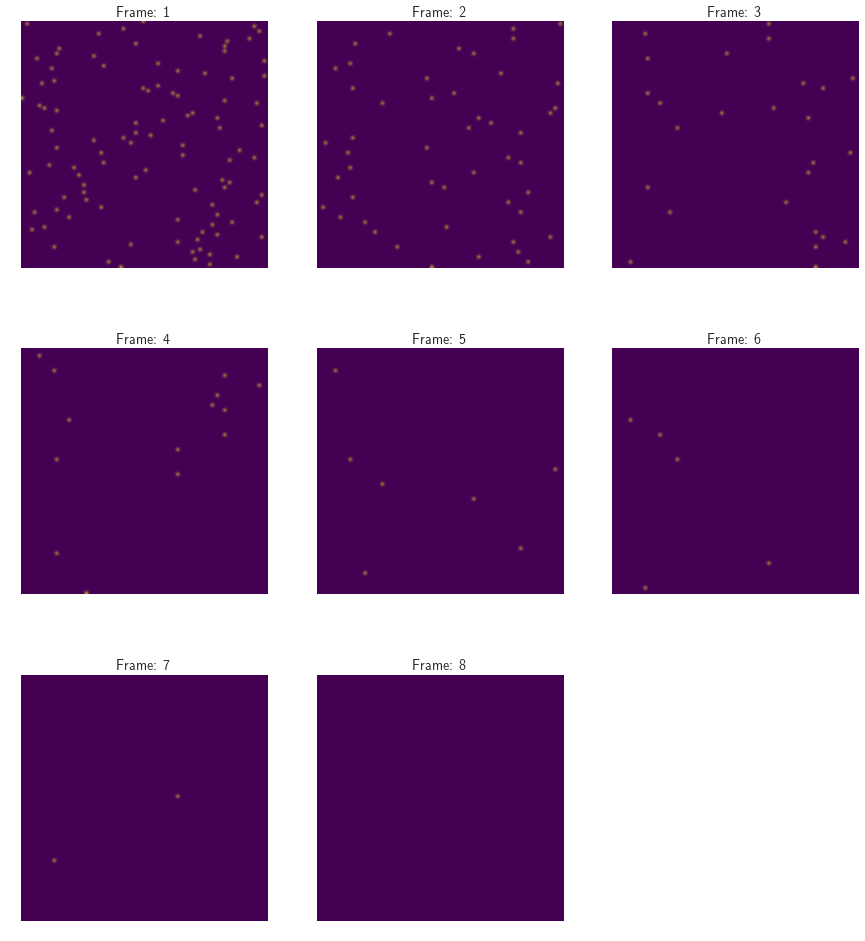

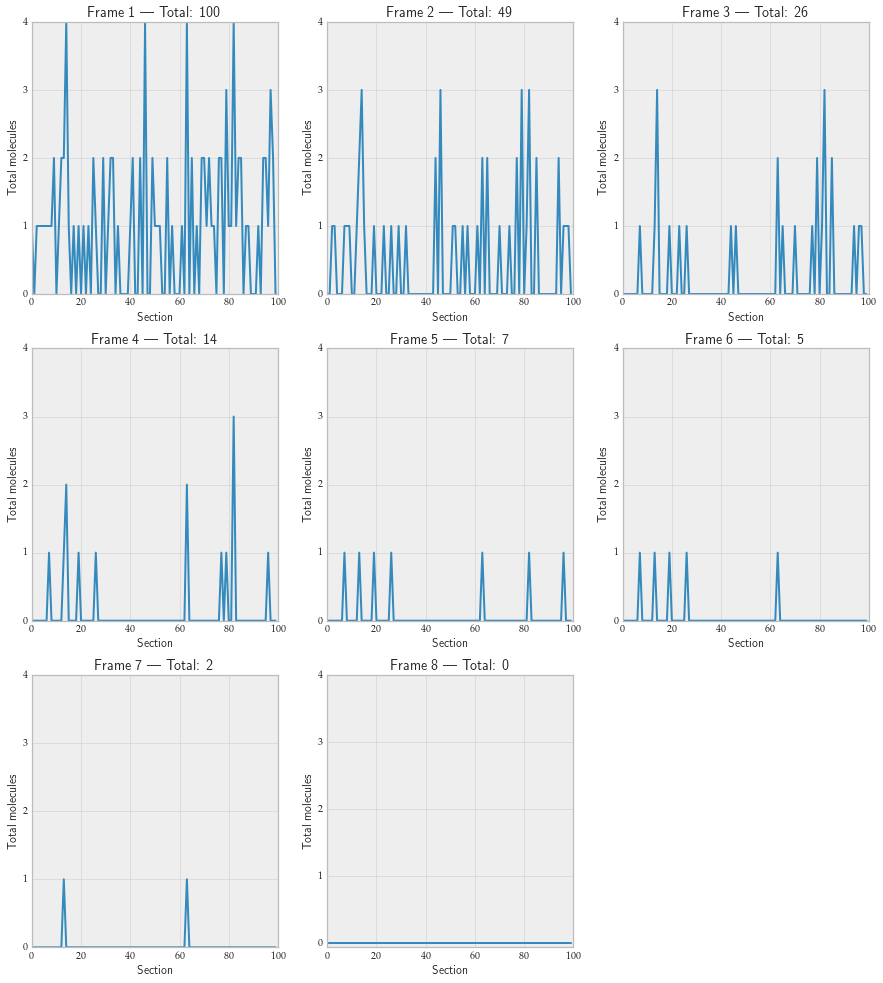

In [351]:
style.use('bmh')

cell = randint(0, 100, 100)

img = zeros([100, 100])

fig = list()
cell_data = list()
fig.append(figure(figsize=[15, 40]))

for ind, val in enumerate(cell):
    img[ind, val]=1

vals = list()

vals.append(sum(img, axis=0))

fig[-1].add_subplot(731)
cell_data.append(img)
imshow(img, interpolation='bicubic', cmap=cm.viridis)
title('Frame: {}'.format(1))
grid('off')
axis('off')

iteration = 2
while any(cell)>0:
    img = zeros([100, 100])
    shuffle(cell)
    cell[::2] = 0
    for ind, val in enumerate(cell):
        if val != 0:
            img[ind, val]=1

    fig[-1].add_subplot(7,3, iteration)  
    imshow(img, interpolation='bicubic', cmap=cm.viridis)
    cell_data.append(img)
    grid('off')
    axis('off')
    vals.append(sum(img, axis=0))
    title('Frame: {}'.format(iteration))
    iteration += 1

 

fig.append(figure(figsize=[15, 40]))

for ind, item in enumerate(vals):
    fig[-1].add_subplot(7,3, ind+1)  
    plot(item)
    title('Frame {} | Total: {}'.format(ind+1, int(sum(item))))
    xlabel('Section')
    ylabel('Total molecules')
    ax = gca()
    ax.set_yticks([0, 1, 2, 3, 4])


file_names = ['cells', 'cells-freq']
for ind, item in enumerate(fig):
    item.savefig('./notebook_images/' + file_names[ind] + '.eps',
                 dpi=300,
                 format='eps',
                 bbox_inches='tight',
                 transparent=True,
                 frameon=None)

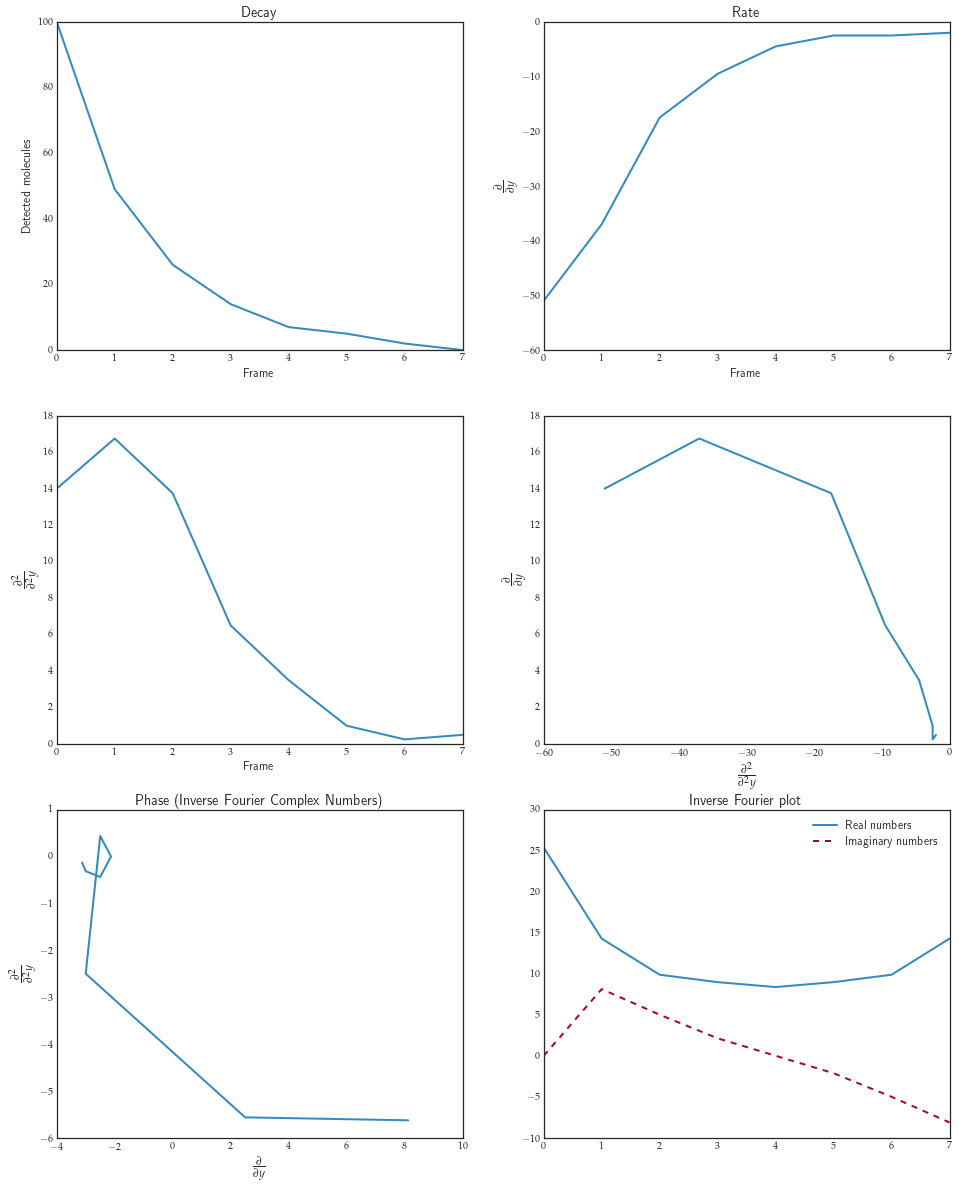

In [352]:
style.use('seaborn-white')
fig = figure(figsize=[16, 20])
fig.add_subplot(321)

plot(sum(vals, axis=1))
xlabel(r'Frame')
ylabel(r'Detected molecules')
title('Decay')

fig.add_subplot(322)
plot(gradient(sum(vals, axis=1)))
xlabel(r'Frame')
ylabel(r'$\frac{\partial}{\partial y}$', fontsize=16)
title('Rate')

fig.add_subplot(323)
plot(gradient(gradient(sum(vals, axis=1))))
xlabel(r'Frame')
ylabel(r'$\frac{\partial^2}{\partial^2 y}$', fontsize=16)


fig.add_subplot(324)
plot(gradient(sum(vals, axis=1)), gradient(gradient(sum(vals, axis=1))))
xlabel(r'$\frac{\partial^2}{\partial^2 y}$', fontsize=16)
ylabel(r'$\frac{\partial}{\partial y}$', fontsize=16)


fig.add_subplot(325)
plot(gradient(ifft(sum(vals, axis=1))).imag, gradient(gradient(ifft(sum(vals, axis=1)).imag)))
title('Phase (Inverse Fourier Complex Numbers)')
ylabel(r'$\frac{\partial^2}{\partial^2 y}$', fontsize=16)
xlabel(r'$\frac{\partial}{\partial y}$', fontsize=16)

fig.add_subplot(326)
plot(ifft(sum(vals, axis=1)).real, '-', ifft(sum(vals, axis=1)).imag, '--')
legend(['Real numbers', 'Imaginary numbers'])
title('Inverse Fourier plot')

fig.savefig('./notebook_images/sumplot.eps',
             dpi=300,
             format='eps',
             bbox_inches='tight',
             transparent=True,
             frameon=None)

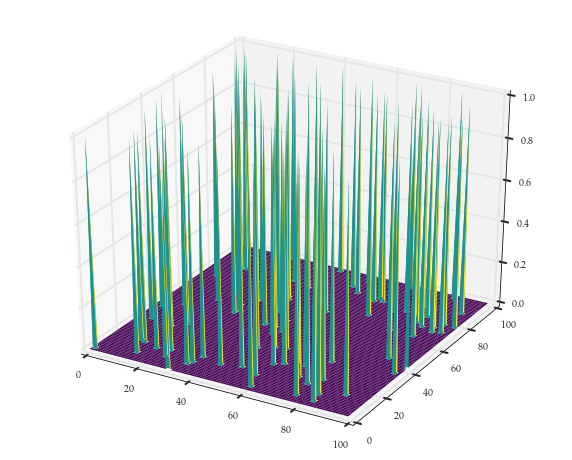

In [360]:
xx, yy = mgrid[0:cell_data[0].shape[0], 0:cell_data[0].shape[1]]
fig = figure(figsize=[10, 8])
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, cell_data[0] ,rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0)
fig.savefig('./notebook_images/surf.eps',
             dpi=300,
             format='eps',
             bbox_inches='tight',
             transparent=True,
             frameon=None)

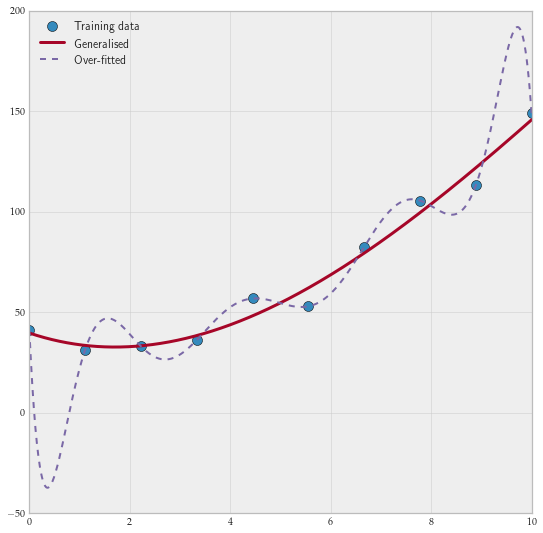

In [345]:
style.use('bmh')

figure(figsize=[9, 9])
x = linspace(0, 10, 10)
y = [i+randint(20, 50) for i in x**2]
plot(x, y, 'o', markersize=10, label='Training data')

nor = polyfit(x, y, deg=3)
pnor = poly1d(nor)
over = polyfit(x, y, deg=9)
pover = poly1d(over)

xp = linspace(0,10,1000)
plot(xp, pnor(xp), '-', linewidth=3, label='Generalised')
plot(xp, pover(xp), '--', linewidth=2, label='Over-fitted')
legend(loc='best')

## Reverse Fourier Transform
Example of conducting a mathematical operation on the vectors and its comparative simplicity. 

$$(\mathcal{F}f_{Axin})(\xi)$$

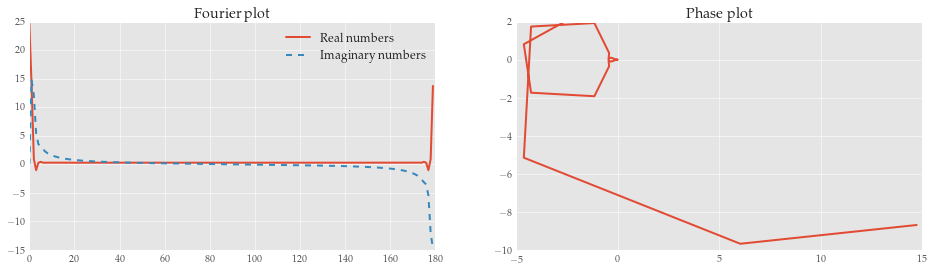

In [209]:
style.use('ggplot')
fig = figure(figsize=[16,9])
fig.add_subplot(221)
plot(ifft(items['Axin']).real, '-', ifft(items['Axin']).imag, '--', linewidth=2)
legend(['Real numbers', 'Imaginary numbers'])
title('Fourier plot')

fig.add_subplot(222)
plot(gradient(ifft(items['Axin'])).imag, gradient(gradient(ifft(items['Axin']).imag)))
title('Phase plot')

Schnell and Mendoza:
$$F(t) = S_{init} \times \mathrm{e}^{(-Bt)}$$
$$ = \frac{[S]_0}{K_\mathrm{M}} \times \exp{\left(\frac{[S]_0}{K_\mathrm{M}} - \frac{V_{max}}{K_\mathrm{M}}\times t \right)} $$

Sigmoid:
$$P(t)=A+\frac{K-A}{(1+S_{0}\times\mathrm{e}^{-Bt})^{\frac{1}{v}}}$$

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in power


(-5, 105)

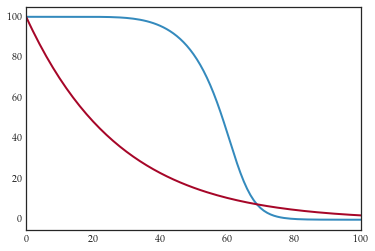

In [314]:
m_m = (max_time/halflife_t)*exp((max_time/halflife_t)-(halflife/halflife_t)*t_span)
# plot(m_m)

def func(y, t):
    return (y)/-(1 +(exp((y/t)*decay_constant)) ** (1/decay_constant))

def fn(y, t):
    return (y*decay_constant)-exp((decay_constant*t))


from scipy.integrate import odeint
sig = odeint(func, y0=100, t=t_span)
mm = odeint(fn, y0=100, t=t_span)
plot(sig)
plot(mm)
xlim([0,100])
ylim([-5, 105])

# Comparison of different training algorithms
Comparison of different training algorithms using \textit{cross entropy (CEE)} and \textit{squared sum (SEE)} error functions. Simulations have been compared to measured data through analysis of variance (ANOVA); p-values were obtained for individual components (Axin, Dsh, TCP, and Buffer).

In [15]:
from scipy.stats import f_oneway
from simulator import Model

t_span_p = array([0, 30, 60, 120, 180]).reshape(-1, 1)

## Newton-Conjugate gradient (Newton-CG) with cross entropy error function.

In [22]:
model = Model(training_data)
model.MaxError = 1e-2
model.TrainingAlgorithm = 'Newton-Conjugate gradient (Newton-CG)'
net = model.run(plotit=False)

test_results = [None] * 10
for index, __ in enumerate(test_results):
    net = model.run(plotit=False, verbose=False)
    simulated = net.sim(t_span_p / max_samples) * max_time
    tmp = f_oneway(simulated, data['target'].T).pvalue
    print('Round {} | {}:{:.3f}, {}:{:.3f}, {}:{:.3f}, {}:{:.3f}'.format(
            index+1, 
            data['titles'][0], tmp[0], 
            data['titles'][1], tmp[1], 
            data['titles'][2], tmp[2], 
            data['titles'][3], tmp[3]))
    
    test_results[index] = tmp.mean()

print('Average ANOVA: {:.3f}'.format(sum(test_results)/len(test_results)))

╒════════════════════╤═══════════════════════════════════════╕
│ co                 │ 4                                     │
├────────────────────┼───────────────────────────────────────┤
│ ci                 │ 1                                     │
├────────────────────┼───────────────────────────────────────┤
│ Inputs dim         │ (5, 1)                                │
├────────────────────┼───────────────────────────────────────┤
│ Outputs dim        │ (5, 4)                                │
├────────────────────┼───────────────────────────────────────┤
│ Training algorithm │ Newton-Conjugate gradient (Newton-CG) │
├────────────────────┼───────────────────────────────────────┤
│ Cost algorithm     │ Cross Entropy                         │
├────────────────────┼───────────────────────────────────────┤
│ Number of layers   │ 3                                     │
╘════════════════════╧═══════════════════════════════════════╛ 

>> Training is initialised...


                     

## Newton-Conjugate gradient (Newton-CG) with squared sum error function.

In [21]:
model = Model(training_data)
model.MaxError = 1e-3
model.TrainingAlgorithm = 'Newton-Conjugate gradient (Newton-CG)'
model.ErrorFunction = 'Squared Sum'
net = model.run(plotit=False)

test_results = [None] * 10
for index, __ in enumerate(test_results):
    net = model.run(plotit=False, verbose=False)
    simulated = net.sim(t_span_p / max_samples) * max_time
    tmp = f_oneway(simulated, data['target'].T).pvalue
    print('Round {} | {}:{:.3f}, {}:{:.3f}, {}:{:.3f}, {}:{:.3f}'.format(
            index+1, 
            data['titles'][0], tmp[0], 
            data['titles'][1], tmp[1], 
            data['titles'][2], tmp[2], 
            data['titles'][3], tmp[3]))
    
    test_results[index] = tmp.mean()

print('Average ANOVA: {:.3f}'.format(sum(test_results)/len(test_results)))

╒════════════════════╤═══════════════════════════════════════╕
│ co                 │ 4                                     │
├────────────────────┼───────────────────────────────────────┤
│ ci                 │ 1                                     │
├────────────────────┼───────────────────────────────────────┤
│ Inputs dim         │ (5, 1)                                │
├────────────────────┼───────────────────────────────────────┤
│ Outputs dim        │ (5, 4)                                │
├────────────────────┼───────────────────────────────────────┤
│ Training algorithm │ Newton-Conjugate gradient (Newton-CG) │
├────────────────────┼───────────────────────────────────────┤
│ Cost algorithm     │ Squared Sum                           │
├────────────────────┼───────────────────────────────────────┤
│ Number of layers   │ 3                                     │
╘════════════════════╧═══════════════════════════════════════╛ 

>> Training is initialised...

The goal of learning i

## Broyden Fletcher Goldfarb Shanno (BFGS) with cross entropy error function.

In [10]:
model = Model(training_data)
model.MaxError = 1e-2
model.TrainingAlgorithm = 'Broyden Fletcher Goldfarb Shanno (BFGS)'
net = model.run(plotit=False)

test_results = [None] * 10
for index, __ in enumerate(test_results):
    net = model.run(plotit=False, verbose=False)
    simulated = net.sim(t_span_p / max_samples) * max_time
    tmp = f_oneway(simulated, data['target'].T).pvalue
    print('Round {} | {}:{:.3f}, {}:{:.3f}, {}:{:.3f}, {}:{:.3f}'.format(
            index+1, 
            data['titles'][0], tmp[0], 
            data['titles'][1], tmp[1], 
            data['titles'][2], tmp[2], 
            data['titles'][3], tmp[3]))
    
    test_results[index] = tmp.mean()

print('Average ANOVA: {:.3f}'.format(sum(test_results)/len(test_results)))

╒════════════════════╤═════════════════════════════════════════╕
│ co                 │ 4                                       │
├────────────────────┼─────────────────────────────────────────┤
│ ci                 │ 1                                       │
├────────────────────┼─────────────────────────────────────────┤
│ Inputs dim         │ (5, 1)                                  │
├────────────────────┼─────────────────────────────────────────┤
│ Outputs dim        │ (5, 4)                                  │
├────────────────────┼─────────────────────────────────────────┤
│ Training algorithm │ Broyden Fletcher Goldfarb Shanno (BFGS) │
├────────────────────┼─────────────────────────────────────────┤
│ Cost algorithm     │ Cross Entropy                           │
├────────────────────┼─────────────────────────────────────────┤
│ Number of layers   │ 3                                       │
╘════════════════════╧═════════════════════════════════════════╛ 

>> Training is initiali

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/neurolab/trans.py:107: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


## Broyden Fletcher Goldfarb Shanno (BFGS) with squared sum error function.

In [11]:
model = Model(training_data)
model.MaxError = 1e-2
model.TrainingAlgorithm = 'Broyden Fletcher Goldfarb Shanno (BFGS)'
model.ErrorFunction = 'Squared Sum'
net = model.run(plotit=False)

test_results = [None] * 10
for index, __ in enumerate(test_results):
    net = model.run(plotit=False, verbose=False)
    simulated = net.sim(t_span_p / max_samples) * max_time
    tmp = f_oneway(simulated, data['target'].T).pvalue
    print('Round {} | {}:{:.3f}, {}:{:.3f}, {}:{:.3f}, {}:{:.3f}'.format(
            index+1, 
            data['titles'][0], tmp[0], 
            data['titles'][1], tmp[1], 
            data['titles'][2], tmp[2], 
            data['titles'][3], tmp[3]))
    
    test_results[index] = tmp.mean()

print('Average ANOVA: {:.3f}'.format(sum(test_results)/len(test_results)))

╒════════════════════╤═════════════════════════════════════════╕
│ co                 │ 4                                       │
├────────────────────┼─────────────────────────────────────────┤
│ ci                 │ 1                                       │
├────────────────────┼─────────────────────────────────────────┤
│ Inputs dim         │ (5, 1)                                  │
├────────────────────┼─────────────────────────────────────────┤
│ Outputs dim        │ (5, 4)                                  │
├────────────────────┼─────────────────────────────────────────┤
│ Training algorithm │ Broyden Fletcher Goldfarb Shanno (BFGS) │
├────────────────────┼─────────────────────────────────────────┤
│ Cost algorithm     │ Squared Sum                             │
├────────────────────┼─────────────────────────────────────────┤
│ Number of layers   │ 3                                       │
╘════════════════════╧═════════════════════════════════════════╛ 

>> Training is initiali

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/neurolab/trans.py:107: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/neurolab/trans.py:107: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))



Round 1 | Axin:0.982, Buffer:0.738, Dsh:0.736, TCF:0.086
Round 2 | Axin:0.999, Buffer:0.962, Dsh:0.855, TCF:0.086
The goal of learning is reached
Round 3 | Axin:0.991, Buffer:0.958, Dsh:0.971, TCF:0.801
Round 4 | Axin:0.999, Buffer:0.987, Dsh:0.885, TCF:0.086
Round 5 | Axin:0.999, Buffer:0.987, Dsh:0.885, TCF:0.086

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/neurolab/trans.py:107: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/neurolab/trans.py:107: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))



Round 6 | Axin:0.933, Buffer:0.779, Dsh:0.709, TCF:0.086

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/neurolab/trans.py:107: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/neurolab/trans.py:107: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))



Round 7 | Axin:0.990, Buffer:0.744, Dsh:0.670, TCF:0.086
Round 8 | Axin:0.992, Buffer:0.733, Dsh:0.752, TCF:0.721

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/neurolab/trans.py:107: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/neurolab/trans.py:107: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))



Round 9 | Axin:0.945, Buffer:0.748, Dsh:0.719, TCF:0.605
Round 10 | Axin:0.988, Buffer:0.978, Dsh:0.883, TCF:0.086
Average ANOVA: 0.731


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/neurolab/trans.py:107: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/neurolab/trans.py:107: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


## Gradient descent backpropagation (GD) with cross entropy error function.
Training stopped at 100k epochs.

In [20]:
model = Model(training_data)
model.MaxError = 1e-2
model.TrainingAlgorithm = 'Gradient descent backpropagation (GD)'
model.Training = 1e5
model.ReportInterval = 5e4
net = model.run(plotit=False)

test_results = [None] * 10
for index, __ in enumerate(test_results):
    net = model.run(plotit=False, verbose=False)
    simulated = net.sim(t_span_p / max_samples) * max_time
    tmp = f_oneway(simulated, data['target'].T).pvalue
    print('Round {} | {}:{:.3f}, {}:{:.3f}, {}:{:.3f}, {}:{:.3f}'.format(
            index+1, 
            data['titles'][0], tmp[0], 
            data['titles'][1], tmp[1], 
            data['titles'][2], tmp[2], 
            data['titles'][3], tmp[3]))
    
    test_results[index] = tmp.mean()

print('Average ANOVA: {:.3f}'.format(sum(test_results)/len(test_results)))

╒════════════════════╤═══════════════════════════════════════╕
│ co                 │ 4                                     │
├────────────────────┼───────────────────────────────────────┤
│ ci                 │ 1                                     │
├────────────────────┼───────────────────────────────────────┤
│ Inputs dim         │ (5, 1)                                │
├────────────────────┼───────────────────────────────────────┤
│ Outputs dim        │ (5, 4)                                │
├────────────────────┼───────────────────────────────────────┤
│ Training algorithm │ Gradient descent backpropagation (GD) │
├────────────────────┼───────────────────────────────────────┤
│ Cost algorithm     │ Cross Entropy                         │
├────────────────────┼───────────────────────────────────────┤
│ Number of layers   │ 3                                     │
╘════════════════════╧═══════════════════════════════════════╛ 

>> Training is initialised...

Epoch: 50000; Error: 0

## Gradient descent backpropagation (GD) with squared sum error function.
Training stopped at 100k epochs.

In [19]:
model = Model(training_data)
model.MaxError = 1e-2
model.TrainingAlgorithm = 'Gradient descent backpropagation (GD)'
model.ErrorFunction = 'Squared Sum'
model.Training = 1e5
model.ReportInterval = 5e4
net = model.run(plotit=False)

test_results = [None] * 10
for index, __ in enumerate(test_results):
    net = model.run(plotit=False, verbose=False)
    simulated = net.sim(t_span_p / max_samples) * max_time
    tmp = f_oneway(simulated, data['target'].T).pvalue
    print('Round {} | {}:{:.3f}, {}:{:.3f}, {}:{:.3f}, {}:{:.3f}'.format(
            index+1, 
            data['titles'][0], tmp[0], 
            data['titles'][1], tmp[1], 
            data['titles'][2], tmp[2], 
            data['titles'][3], tmp[3]))
    
    test_results[index] = tmp.mean()

print('Average ANOVA: {:.3f}'.format(sum(test_results)/len(test_results)))

╒════════════════════╤═══════════════════════════════════════╕
│ co                 │ 4                                     │
├────────────────────┼───────────────────────────────────────┤
│ ci                 │ 1                                     │
├────────────────────┼───────────────────────────────────────┤
│ Inputs dim         │ (5, 1)                                │
├────────────────────┼───────────────────────────────────────┤
│ Outputs dim        │ (5, 4)                                │
├────────────────────┼───────────────────────────────────────┤
│ Training algorithm │ Gradient descent backpropagation (GD) │
├────────────────────┼───────────────────────────────────────┤
│ Cost algorithm     │ Squared Sum                           │
├────────────────────┼───────────────────────────────────────┤
│ Number of layers   │ 3                                     │
╘════════════════════╧═══════════════════════════════════════╛ 

>> Training is initialised...

Epoch: 50000; Error: 0

## Gradient descent with adapting learning rate (GDA) with cross entropy error function.
Training stopped at 100k epochs.

In [17]:
model = Model(training_data)
model.MaxError = 1e-2
model.TrainingAlgorithm = 'Gradient descent with adaptive learning rate (GDA)'
model.Training = 1e5
model.ReportInterval = 5e4
net = model.run(plotit=False)

test_results = [None] * 10
for index, __ in enumerate(test_results):
    net = model.run(plotit=False, verbose=False)
    simulated = net.sim(t_span_p / max_samples) * max_time
    tmp = f_oneway(simulated, data['target'].T).pvalue
    print('Round {} | {}:{:.3f}, {}:{:.3f}, {}:{:.3f}, {}:{:.3f}'.format(
            index+1, 
            data['titles'][0], tmp[0], 
            data['titles'][1], tmp[1], 
            data['titles'][2], tmp[2], 
            data['titles'][3], tmp[3]))
    
    test_results[index] = tmp.mean()

print('Average ANOVA: {:.3f}'.format(sum(test_results)/len(test_results)))

╒════════════════════╤════════════════════════════════════════════════════╕
│ co                 │ 4                                                  │
├────────────────────┼────────────────────────────────────────────────────┤
│ ci                 │ 1                                                  │
├────────────────────┼────────────────────────────────────────────────────┤
│ Inputs dim         │ (5, 1)                                             │
├────────────────────┼────────────────────────────────────────────────────┤
│ Outputs dim        │ (5, 4)                                             │
├────────────────────┼────────────────────────────────────────────────────┤
│ Training algorithm │ Gradient descent with adaptive learning rate (GDA) │
├────────────────────┼────────────────────────────────────────────────────┤
│ Cost algorithm     │ Cross Entropy                                      │
├────────────────────┼────────────────────────────────────────────────────┤
│ Number of 

## Gradient descent with adapting learning rate (GDA) with squared sum error function.

In [15]:
model = Model(training_data)
model.MaxError = 1e-2
model.TrainingAlgorithm = 'Gradient descent with adaptive learning rate (GDA)'
model.ErrorFunction = 'Squared Sum'
model.Training = 1e5
model.ReportInterval = 5e4
net = model.run(plotit=False)

test_results = [None] * 10
for index, __ in enumerate(test_results):
    net = model.run(plotit=False, verbose=False)
    simulated = net.sim(t_span_p / max_samples) * max_time
    tmp = f_oneway(simulated, data['target'].T).pvalue
    print('Round {} | {}:{:.3f}, {}:{:.3f}, {}:{:.3f}, {}:{:.3f}'.format(
            index+1, 
            data['titles'][0], tmp[0], 
            data['titles'][1], tmp[1], 
            data['titles'][2], tmp[2], 
            data['titles'][3], tmp[3]))
    
    test_results[index] = tmp.mean()

print('Average ANOVA: {:.3f}'.format(sum(test_results)/len(test_results)))

╒════════════════════╤════════════════════════════════════════════════════╕
│ co                 │ 4                                                  │
├────────────────────┼────────────────────────────────────────────────────┤
│ ci                 │ 1                                                  │
├────────────────────┼────────────────────────────────────────────────────┤
│ Inputs dim         │ (5, 1)                                             │
├────────────────────┼────────────────────────────────────────────────────┤
│ Outputs dim        │ (5, 4)                                             │
├────────────────────┼────────────────────────────────────────────────────┤
│ Training algorithm │ Gradient descent with adaptive learning rate (GDA) │
├────────────────────┼────────────────────────────────────────────────────┤
│ Cost algorithm     │ Squared Sum                                        │
├────────────────────┼────────────────────────────────────────────────────┤
│ Number of 

## Conjugate gradient (NCG) with cross entropy error function.

In [23]:
model = Model(training_data)
model.MaxError = 1e-2
model.TrainingAlgorithm = 'Conjugate gradient (NCG)'
net = model.run(plotit=False)

test_results = [None] * 10
for index, __ in enumerate(test_results):
    net = model.run(plotit=False, verbose=False)
    simulated = net.sim(t_span_p / max_samples) * max_time
    tmp = f_oneway(simulated, data['target'].T).pvalue
    print('Round {} | {}:{:.3f}, {}:{:.3f}, {}:{:.3f}, {}:{:.3f}'.format(
            index+1, 
            data['titles'][0], tmp[0], 
            data['titles'][1], tmp[1], 
            data['titles'][2], tmp[2], 
            data['titles'][3], tmp[3]))
    
    test_results[index] = tmp.mean()

print('Average ANOVA: {:.3f}'.format(sum(test_results)/len(test_results)))

╒════════════════════╤══════════════════════════╕
│ co                 │ 4                        │
├────────────────────┼──────────────────────────┤
│ ci                 │ 1                        │
├────────────────────┼──────────────────────────┤
│ Inputs dim         │ (5, 1)                   │
├────────────────────┼──────────────────────────┤
│ Outputs dim        │ (5, 4)                   │
├────────────────────┼──────────────────────────┤
│ Training algorithm │ Conjugate gradient (NCG) │
├────────────────────┼──────────────────────────┤
│ Cost algorithm     │ Cross Entropy            │
├────────────────────┼──────────────────────────┤
│ Number of layers   │ 3                        │
╘════════════════════╧══════════════════════════╛ 

>> Training is initialised...

Optimization terminated successfully.
         Current function value: 0.319972
         Iterations: 226
         Function evaluations: 482
         Gradient evaluations: 235105
         Hessian evaluations: 0

      

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/neurolab/trans.py:107: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


## Conjugate gradient (NCG) with squared sum error function.

In [13]:
model = Model(training_data)
model.MaxError = 1e-2
model.TrainingAlgorithm = 'Conjugate gradient (NCG)'
model.ErrorFunction = 'Squared Sum'
net = model.run(plotit=False)

test_results = [None] * 10
for index, __ in enumerate(test_results):
    net = model.run(plotit=False, verbose=False)
    simulated = net.sim(t_span_p / max_samples) * max_time
    tmp = f_oneway(simulated, data['target'].T).pvalue
    print('Round {} | {}:{:.3f}, {}:{:.3f}, {}:{:.3f}, {}:{:.3f}'.format(
            index+1, 
            data['titles'][0], tmp[0], 
            data['titles'][1], tmp[1], 
            data['titles'][2], tmp[2], 
            data['titles'][3], tmp[3]))
    
    test_results[index] = tmp.mean()

print('Average ANOVA: {:.3f}'.format(sum(test_results)/len(test_results)))

╒════════════════════╤══════════════════════════╕
│ co                 │ 4                        │
├────────────────────┼──────────────────────────┤
│ ci                 │ 1                        │
├────────────────────┼──────────────────────────┤
│ Inputs dim         │ (5, 1)                   │
├────────────────────┼──────────────────────────┤
│ Outputs dim        │ (5, 4)                   │
├────────────────────┼──────────────────────────┤
│ Training algorithm │ Conjugate gradient (NCG) │
├────────────────────┼──────────────────────────┤
│ Cost algorithm     │ Squared Sum              │
├────────────────────┼──────────────────────────┤
│ Number of layers   │ 3                        │
╘════════════════════╧══════════════════════════╛ 

>> Training is initialised...

The goal of learning is reached

                                  Simulation Results                                  
============  =====================================  =================================
  Time (mi

In [21]:
t_span_p = array([0, 30, 60, 120, 180]).reshape(-1, 1)
network.sim(t_span_p/max_samples) * max_time

array([[99.02  , 98.97  , 99.10  , 99.03  ],
       [24.15  , 60.15  , 86.01  , 96.86  ],
       [0.01  , 47.97  , 82.28  , 95.65  ],
       [0.00  , 30.83  , 78.22  , 88.96  ],
       [0.00  , 21.07  , 75.05  , 79.67  ]])